In [1]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

import pandas as pd
from six.moves import xrange
import os

import umap
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import albumentations as A
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

2024-05-01 09:09:22.249767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 09:09:22.249860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 09:09:22.379104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import wandb
import random
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [5]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [6]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [8]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

In [9]:
class CustomDataLoader(Dataset):
    def __init__(self, image_folder, transform=None):
        self.transform = transform
        self.image_folder = image_folder
        self.image_names = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        # Load image
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_folder, image_name)
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image_np = np.array(image)
            transformed = self.transform(image=image_np)
            image = transformed['image']
            # Transpose image array to shape (3, height, width)
            image = np.moveaxis(image, -1, 0)
        
        return image

In [10]:
# Data transformations
transform = A.Compose([
    A.Resize(128, 128),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.RGBShift(),
    A.CoarseDropout(max_holes=3, max_height=5, max_width=5, min_holes=1, min_height=2, min_width=2, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
])

In [11]:
# dataset and dataloader
train_image_folder='/kaggle/input/isci-cgan-dataset/Dataset/Train/Train_data'

test_image_folder='/kaggle/input/isci-cgan-dataset/Dataset/Test/Test_data'


train_dataset = CustomDataLoader(train_image_folder,transform=transform)
training_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CustomDataLoader(test_image_folder,transform=transform)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

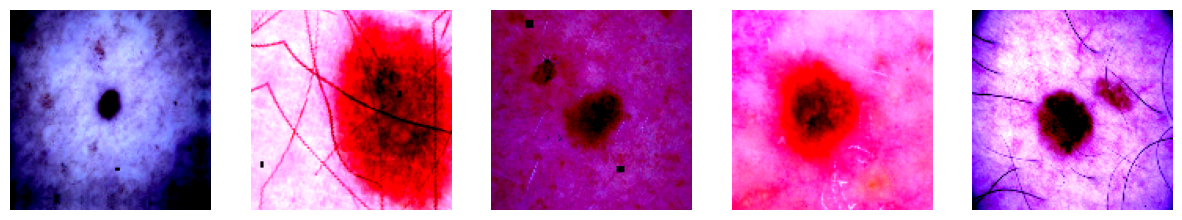

In [12]:
import matplotlib.pyplot as plt

# Define the number of images you want to plot
num_images_to_plot = 5

# Create a subplot grid with appropriate number of rows and columns
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))

# Iterate over the first few images in the train_loader and plot them
for i in range(num_images_to_plot):
    # Get the image from the train_loader
    image = train_dataset[i]
    
    # If the image is in tensor format, convert it to numpy array
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    
    # If the image is in (3, H, W) format, transpose it to (H, W, 3)
    if image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    # Plot the image
    axes[i].imshow(image)
    axes[i].axis('off')

# Show the plot
plt.show()

In [37]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [38]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity, quantized

In [39]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [40]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [17]:
all_image_arrays = []
for idx in range(len(training_loader)):
    image = next(iter(training_loader))
    all_image_arrays.append(image)

In [18]:
data_variance = np.var(all_image_arrays)
print("Variance of original images:", data_variance)

Variance of original images: 0.5998484


In [19]:
# model.train()
# train_res_recon_error = []
# train_res_perplexity = []

# for i in xrange(num_training_updates):
#     (image, true_label_image, transformed_sketch, random_label_image) = next(iter(training_loader))
#     data = image.to(device)
#     optimizer.zero_grad()

#     vq_loss, data_recon, perplexity = model(data)
#     recon_error = F.mse_loss(data_recon, data) / data_variance
#     loss = recon_error + vq_loss
#     loss.backward()

#     optimizer.step()

#     train_res_recon_error.append(recon_error.item())
#     train_res_perplexity.append(perplexity.item())

#     if (i+1) % 100 == 0:
#         print('%d iterations' % (i+1))
#         print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
#         print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
#         print()

In [54]:
from tqdm import tqdm

model.train()
train_res_recon_error = []
train_res_perplexity = []

quantized_vector = []

num_epochs = 5  # Set the number of epochs

for epoch in range(num_epochs):
    epoch_res_recon_error = []
    epoch_res_perplexity = []

    # Wrap the training_loader with tqdm to create a progress bar
    with tqdm(training_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as progress_bar:
        for i, image in enumerate(progress_bar):
            data = image.to(device)
            #print(data.shape)
            optimizer.zero_grad()

            vq_loss, data_recon, perplexity, quantized = model(data)
            quantized_vector.append(quantized)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()

            train_res_recon_error.append(recon_error.item())
            train_res_perplexity.append(perplexity.item())

            epoch_res_recon_error.append(recon_error.item())
            epoch_res_perplexity.append(perplexity.item())

            # Update the progress bar description with relevant statistics
            progress_bar.set_postfix({"Recon Error": np.mean(train_res_recon_error[-100:]), "Perplexity": np.mean(train_res_perplexity[-100:])})

    # Print epoch-level statistics
    print(f"Epoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"Average Reconstruction Error: {np.mean(epoch_res_recon_error):.3f}")
    print(f"Average Perplexity: {np.mean(epoch_res_perplexity):.3f}")
    print()

Epoch 1/5: 100%|██████████| 157/157 [01:22<00:00,  1.91batch/s, Recon Error=0.149, Perplexity=11]  


Epoch [1/5] Summary:
Average Reconstruction Error: 0.167
Average Perplexity: 9.433



Epoch 2/5: 100%|██████████| 157/157 [01:21<00:00,  1.92batch/s, Recon Error=0.105, Perplexity=18]  


Epoch [2/5] Summary:
Average Reconstruction Error: 0.109
Average Perplexity: 17.133



Epoch 3/5: 100%|██████████| 157/157 [01:21<00:00,  1.92batch/s, Recon Error=0.0881, Perplexity=21.7]


Epoch [3/5] Summary:
Average Reconstruction Error: 0.090
Average Perplexity: 21.109



Epoch 4/5: 100%|██████████| 157/157 [01:23<00:00,  1.89batch/s, Recon Error=0.0802, Perplexity=24.2]


Epoch [4/5] Summary:
Average Reconstruction Error: 0.082
Average Perplexity: 23.883



Epoch 5/5: 100%|██████████| 157/157 [01:23<00:00,  1.89batch/s, Recon Error=0.0767, Perplexity=26.2]

Epoch [5/5] Summary:
Average Reconstruction Error: 0.077
Average Perplexity: 25.874



In [55]:
torch.save(model.state_dict(), '/kaggle/working/vq_vae_model.pth')

# Or save individual components
torch.save(model._encoder.state_dict(), '/kaggle/working/encoder.pth')
torch.save(model._pre_vq_conv.state_dict(), '/kaggle/working/prevqconv.pth')
torch.save(model._vq_vae.state_dict(), '/kaggle/working/prevq.pth')
torch.save(model._decoder.state_dict(), '/kaggle/working/decoder.pth')

In [56]:
len(quantized_vector)

785

In [57]:
quantized_vector[0].shape

torch.Size([64, 64, 32, 32])

In [58]:
#new_data = torch.cat(quantized_vector, dim=0)

In [59]:
# new_data.shape

In [60]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

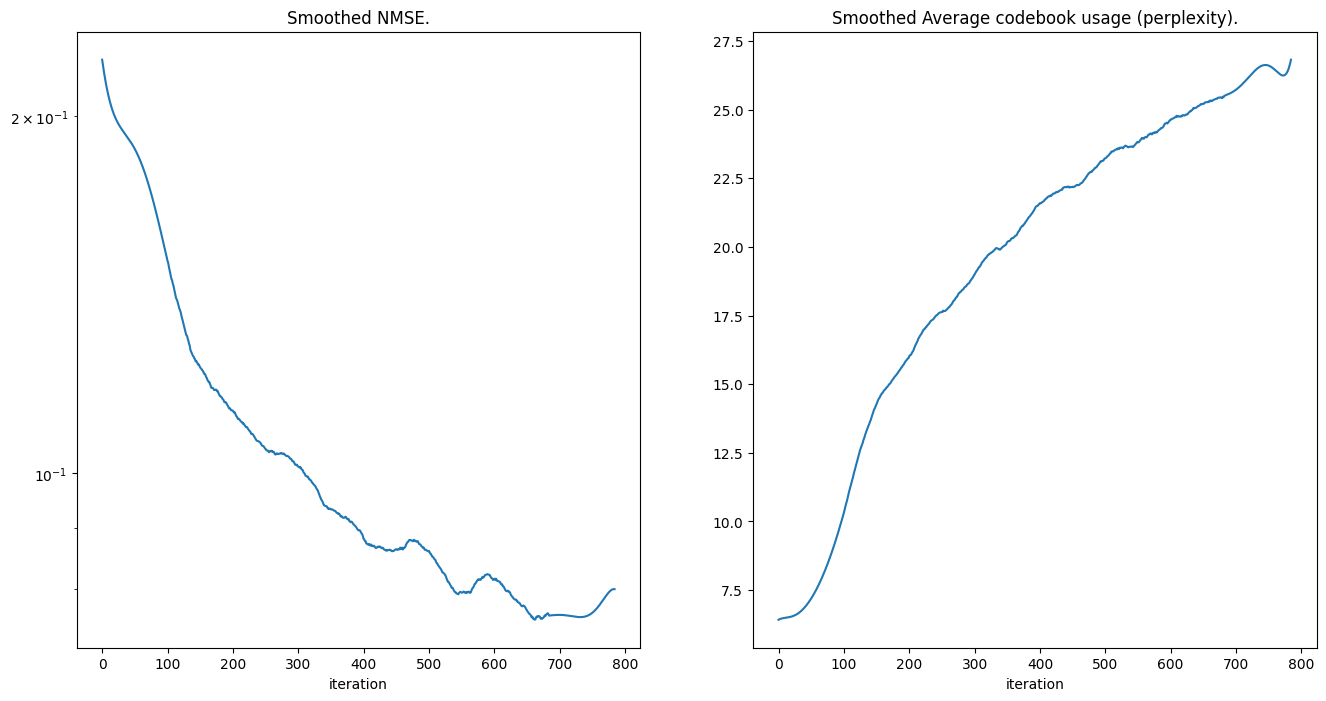

In [61]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [62]:
model.eval()

valid_originals = next(iter(test_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [63]:
train_originals = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [64]:
def show(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    # Denormalize the image
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor to numpy array and rearrange dimensions
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean
    img = np.clip(img, 0, 1)  # Clip to ensure pixel values are between 0 and 1

    # Plot the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

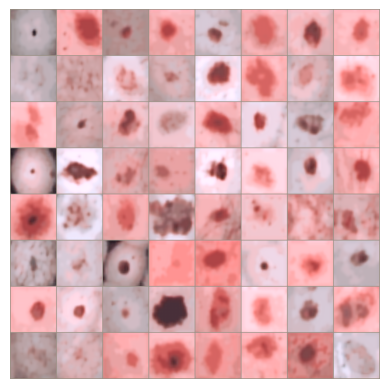

In [65]:
show(make_grid(valid_reconstructions.cpu().data)+0.5)

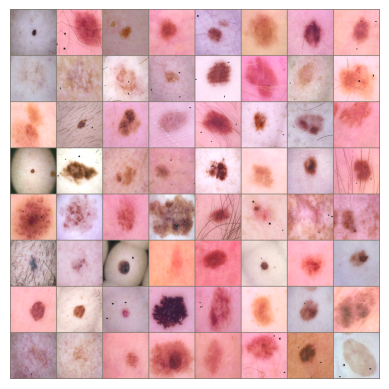

In [66]:
show(make_grid(valid_originals.cpu()+0.5))

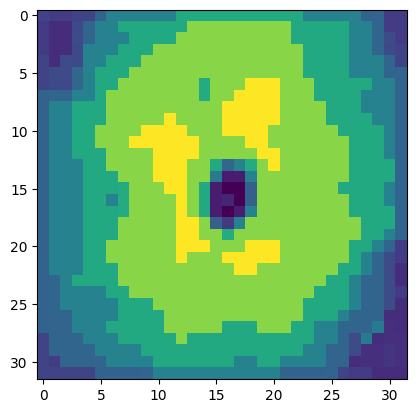

In [67]:
valid_quantize_cpu = valid_quantize.cpu()
valid_quantize_np = valid_quantize_cpu.detach().numpy()
plt.imshow(valid_quantize_np.reshape(-1, 32, 32)[4])
plt.show()

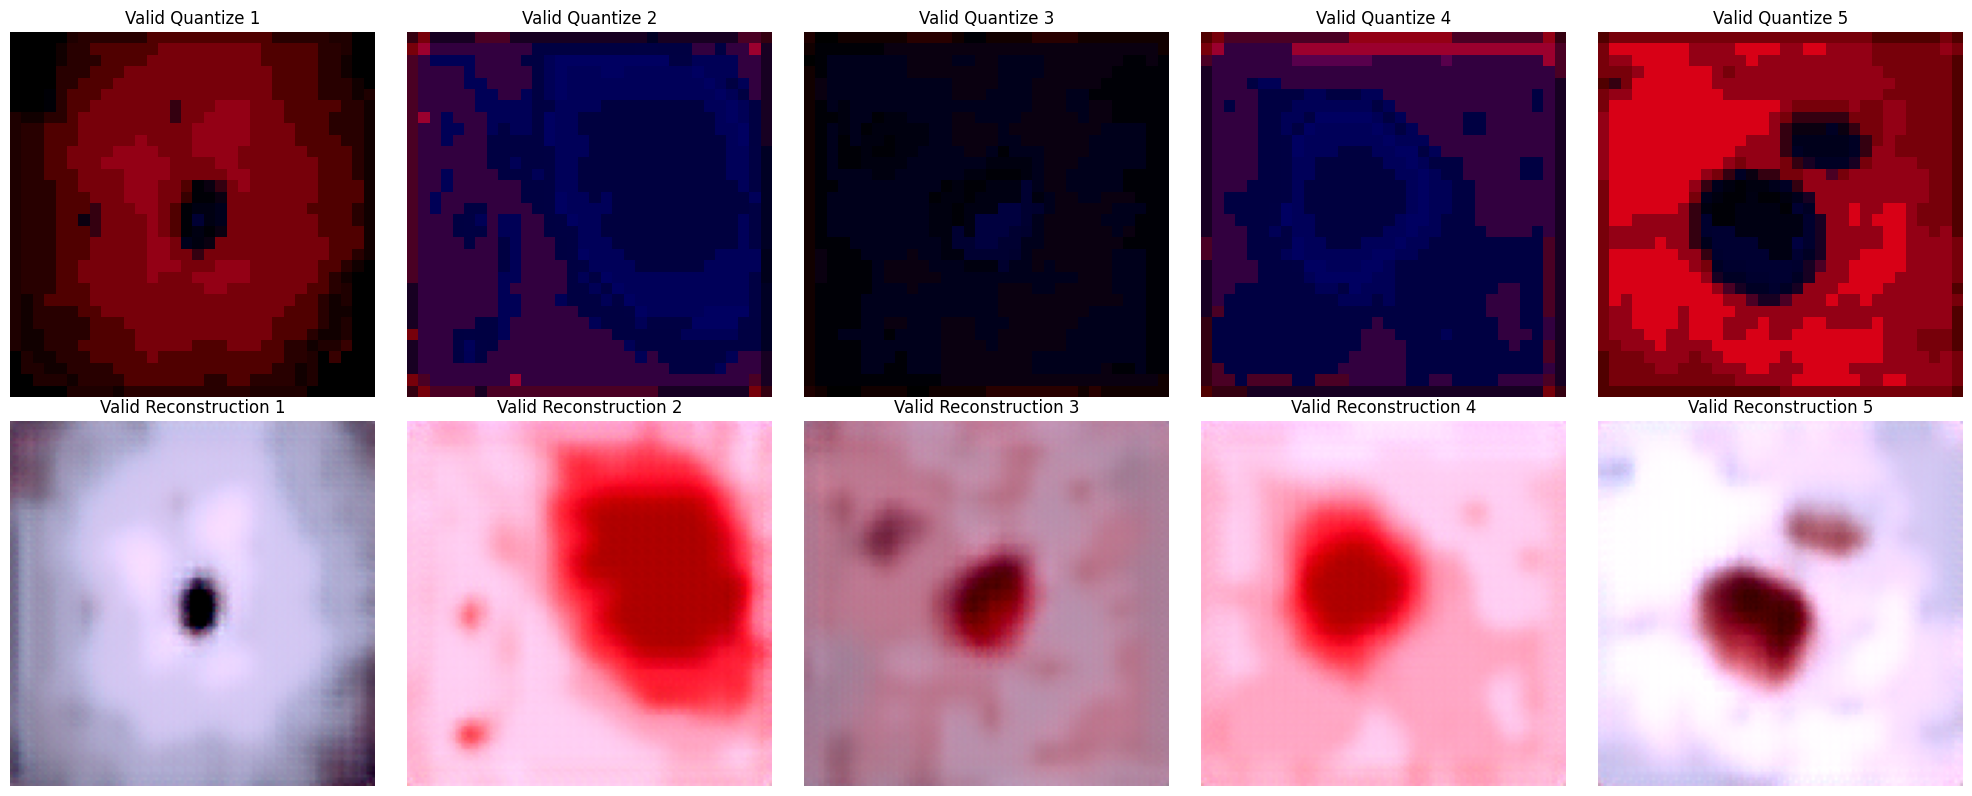

In [72]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Plot the figures
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot valid_quantize
for i in range(5):
    # Select the first 5 channels
    valid_quantize_channel = valid_quantize[i, :3].detach().cpu().permute(1, 2, 0)  # Moving tensor to CPU
    axes[0, i].imshow(valid_quantize_channel)
    axes[0, i].axis('off')
    axes[0, i].set_title('Valid Quantize {}'.format(i+1))

# Plot valid_reconstructions
for i in range(5):
    # Normalize the reconstructions
    valid_reconstructions_normalized = ((valid_reconstructions[i].detach().cpu().permute(1, 2, 0) + 1) / 2).numpy()  # Moving tensor to CPU and converting to numpy

    axes[1, i].imshow(valid_reconstructions_normalized)
    axes[1, i].axis('off')
    axes[1, i].set_title('Valid Reconstruction {}'.format(i+1))

plt.tight_layout()
plt.show()

In [77]:
import torch
from torch.utils.data import Dataset, DataLoader

class PixelCNNDataset(Dataset):
    def __init__(self, quantized_vector):
        self.quantized_vector = quantized_vector
        self.total_length = sum(len(tensor) for tensor in quantized_vector)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        offset = 0
        for tensor in self.quantized_vector:
            if idx < offset + len(tensor):
                return tensor[idx - offset]
            offset += len(tensor)
        raise IndexError(f'Index {idx} is out of range')

# Create the dataset
pixelcnn_dataset = PixelCNNDataset(quantized_vector)

In [79]:
pixelcnn_data_loader = DataLoader(pixelcnn_dataset, batch_size=64, shuffle=True)

In [90]:
pixelcnn_data_loader.batch_size

64

In [101]:
for batch in pixelcnn_data_loader:
    pixelcnn_input_shape=batch.shape
    break
print(pixelcnn_input_shape)

torch.Size([64, 64, 32, 32])


In [94]:
len(pixelcnn_data_loader)

783

In [96]:
# Sample a few tensors from the dataset
num_samples = 5
sample_indices = [0, 100, 200, 300, 400]  # Example indices

for idx in sample_indices:
    sample_tensor = pixelcnn_dataset[idx]
    print("Sample Shape:", sample_tensor.shape)

Sample Shape: torch.Size([64, 32, 32])
Sample Shape: torch.Size([64, 32, 32])
Sample Shape: torch.Size([64, 32, 32])
Sample Shape: torch.Size([64, 32, 32])
Sample Shape: torch.Size([64, 32, 32])


In [84]:
class PixelConvLayer(nn.Module):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.mask_type = mask_type
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.build_mask(kernel_size)

    def build_mask(self, kernel_size):
        mask = torch.ones((kernel_size, kernel_size), dtype=torch.float32)
        mask[kernel_size // 2, kernel_size // 2 + 1 :] = 0
        mask[kernel_size // 2 + 1 :] = 0
        if self.mask_type == "B":
            mask[kernel_size // 2, kernel_size // 2] = 0
        self.register_buffer("mask", mask)

    def forward(self, x):
        self.conv.weight.data *= self.mask
        return self.conv(x)

In [85]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1)
        self.pixel_conv = PixelConvLayer(mask_type="B", in_channels=out_channels // 2, out_channels=out_channels // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        x += identity
        return x

In [86]:
class PixelCNN(nn.Module):
    def __init__(self, num_embeddings, pixelcnn_input_shape, num_residual_blocks, num_pixelcnn_layers):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.pixelcnn_input_shape = pixelcnn_input_shape

        self.pixel_conv_initial = PixelConvLayer(mask_type="A", in_channels=num_embeddings, out_channels=128, kernel_size=7, padding=3)

        self.residual_blocks = nn.ModuleList([ResidualBlock(in_channels=128, out_channels=128) for _ in range(num_residual_blocks)])

        self.pixel_conv_layers = nn.ModuleList([
            PixelConvLayer(mask_type="B", in_channels=128, out_channels=128, kernel_size=1),
            PixelConvLayer(mask_type="B", in_channels=128, out_channels=128, kernel_size=1),
            PixelConvLayer(mask_type="B", in_channels=128, out_channels=num_embeddings, kernel_size=1)
        ])

    def forward(self, x):
        x = self.pixel_conv_initial(x)
        for residual_block in self.residual_blocks:
            x = residual_block(x)
        for pixel_conv_layer in self.pixel_conv_layers:
            x = pixel_conv_layer(x)
        return x

In [105]:
#pixelcnn_input_shape=pixelcnn_data_loader.dataset[0].shape
print(pixelcnn_input_shape)
num_embeddings=64
num_residual_blocks=3
num_pixelcnn_layers=4
pixel_cnn = PixelCNN(num_embeddings, pixelcnn_input_shape, num_residual_blocks, num_pixelcnn_layers)

torch.Size([64, 64, 32, 32])


In [106]:
loss_fn = nn.CrossEntropyLoss()

In [127]:
# num_epochs = 10

# # Move model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# pixel_cnn.to(device)

# # Training loop
# for epoch in range(num_epochs):
#     pixel_cnn.train()  # Set model to training mode
#     total_loss = 0.0
    
#     for batch in pixelcnn_data_loader:
#         #print(batch.shape)
#         batch = batch.to(device)  # Move batch to GPU if available
        
#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         output = pixel_cnn(batch)
        
#         # Flatten the output and target tensors
#         output = output.view(-1)
#         target = batch.view(-1)
#         print(output.shape, target.shape)
#         # Calculate the loss
#         loss = loss_fn(output, target)
#         print(loss.shape)
#         # Backward pass
#         loss.backward()
        
#         # Update the weights
#         optimizer.step()
        
#         # Accumulate the loss
#         total_loss += loss.item()
    
    
#     # Calculate average loss for the epoch
#     avg_loss = total_loss / len(data_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

# print("Training complete!")

In [116]:
# import torch
# from sklearn.model_selection import train_test_split

# # Assuming you have your data tensor named 'all_tensors'

# # Split the data into training and remaining data
# train_data, remaining_data = train_test_split(new_data, test_size=0.2, random_state=42)

# # Split the remaining data into validation and test sets
# val_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

# # Print the sizes of the splits
# print("Train data size:", train_data.size())
# print("Validation data size:", val_data.size())
# print("Test data size:", test_data.size())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert (
            self.head_dim * num_heads == embed_size
        ), "Embedding size must be divisible by number of heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(num_heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.num_heads pieces
        values = values.reshape(N, value_len, self.num_heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.num_heads, self.head_dim)
        queries = query.reshape(N, query_len, self.num_heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) / (
            self.embed_size ** 0.5
        )
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy, dim=-1)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.num_heads * self.head_dim
        )

        out = self.fc_out(out)
        return out


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, ff_hidden_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.ffn = nn.Sequential(
            nn.Linear(embed_size, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, embed_size),
        )
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.ffn(x)
        out = self.dropout(self.norm2(forward + x))
        return out


class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, ff_hidden_dim, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.pos_embedding = nn.Embedding(1000, hidden_size)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden_size, num_heads, ff_hidden_dim, dropout) for _ in range(num_layers)]
        )
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x, mask):
        x = self.embedding(x) + self.pos_embedding(torch.arange(x.shape[1]).to(x.device)).unsqueeze(0)

        for transformer in self.transformer_blocks:
            x = transformer(x, x, x, mask)

        x = self.fc(x)

        return x

    def generate(self, start_token, max_length, temperature=1.0):
        """
        Generate sequence autoregressively.

        Args:
            start_token (torch.Tensor): Initial token to start generation.
            max_length (int): Maximum length of the generated sequence.
            temperature (float): Sampling temperature (controls the level of randomness).

        Returns:
            torch.Tensor: Generated sequence.
        """
        current_token = start_token.unsqueeze(0)  # Add batch dimension
        generated_sequence = [start_token]

        with torch.no_grad():
            for _ in range(max_length):
                logits = self.forward(current_token, mask=None)
                next_token_probs = F.softmax(logits[:, -1, :] / temperature, dim=-1)
                next_token = torch.multinomial(next_token_probs, num_samples=1)
                generated_sequence.append(next_token.squeeze(0))
                current_token = next_token.unsqueeze(0)  # Add batch dimension for next iteration

        return torch.stack(generated_sequence, dim=1)


# Example usage:
input_size = 256  # Input size of the transformer (e.g., vocabulary size)
hidden_size = 512  # Hidden size of the transformer
num_layers = 6  # Number of transformer layers
num_heads = 8  # Number of attention heads
ff_hidden_dim = 1024  # Hidden size of the feedforward layer
dropout = 0.1  # Dropout probability

transformer_model = TransformerModel(input_size, hidden_size, num_layers, num_heads, ff_hidden_dim, dropout)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define your dataset and dataloader
#data = torch.randn(10015, 64, 32, 32)  # Your data tensor of shape (10015, 64, 32, 32)
data = new_data
sequence_length = data.shape[1]
print(sequence_length)

# Flatten the data to make it compatible with the autoregressive model
flattened_data = data.view(-1, sequence_length, data.shape[2] * data.shape[3])
print(flattened_data.shape)

# Split the data into input and target sequences for autoregression
input_sequences = flattened_data[:10, :-1, :10]  # Input sequence: All but the last element

target_sequences = flattened_data[:10, 1:, :10]  # Target sequence: All but the first element

# Convert numpy arrays to PyTorch tensors
input_sequences = torch.tensor(input_sequences, dtype=torch.long)
target_sequences = torch.tensor(target_sequences, dtype=torch.long)

# Define hyperparameters
input_size = 32 * 32  # Size of each element in the input sequence
hidden_size = 256
num_layers = 4
num_heads = 8
ff_hidden_dim = 512
dropout = 0.1
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Create a DataLoader for training
train_dataset = TensorDataset(input_sequences, target_sequences)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the Transformer model
model = TransformerModel(input_size, hidden_size, num_layers, num_heads, ff_hidden_dim, dropout)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, targets[:10, :-1, :10])  # Exclude the last element from the target sequence

        # Calculate the loss
        loss = criterion(outputs.view(-1, input_size), targets[:, 1:, :].contiguous().view(-1))  # Exclude the first element from the target sequence

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch-level statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), 'autoregressive_transformer.pth')